# COVID-19: Global EDA and TS Prediction For Pakistan

### Importing Libraries

In [0]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import preprocessing
from scipy.integrate import odeint
from scipy import integrate, optimize
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_dark"
import matplotlib.pyplot as plt
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

### Data Loading and Cleaning 

Import Population Data



In [2]:
from google.colab import files
uploaded = files.upload()

Saving population_by_country_2020.csv to population_by_country_2020.csv


Import City wise data of Pakistan



In [3]:
#from google.colab import files
uploaded = files.upload()

Saving PK COVID-19-10may.csv to PK COVID-19-10may.csv


In [4]:
pop = pd.read_csv('population_by_country_2020.csv')
pop.head()

,Country (or dependency),Population (2020),Yearly Change,Net Change,Density (P/Km²),Land Area (Km²),Migrants (net),Fert. Rate,Med. Age,Urban Pop %,World Share
0,China,1438207241,0.39 %,5540090,153,9388211,-348399.0,1.7,38,61 %,18.47 %
1,India,1377233523,0.99 %,13586631,464,2973190,-532687.0,2.2,28,35 %,17.70 %
2,United States,330610570,0.59 %,1937734,36,9147420,954806.0,1.8,38,83 %,4.25 %
3,Indonesia,272931713,1.07 %,2898047,151,1811570,-98955.0,2.3,30,56 %,3.51 %
4,Pakistan,219992900,2.00 %,4327022,287,770880,-233379.0,3.6,23,35 %,2.83 %


In [0]:
pop.rename(columns={'Country (or dependency)':'country',
                   'Population (2020)':'population'
                   }, inplace=True)

### Worldwide cleaned data

In [6]:
cleaned_data = pd.read_csv('https://raw.githubusercontent.com/imdevskp/covid_19_jhu_data_web_scrap_and_cleaning/master/covid_19_clean_complete.csv')
#cleaned_data = pd.read_csv('covid_19_clean_complete.csv')
cleaned_data.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,33.0000,65.0000,1/22/20,0,0,0
1,NaN,Albania,41.1533,20.1683,1/22/20,0,0,0
2,NaN,Algeria,28.0339,1.6596,1/22/20,0,0,0
3,NaN,Andorra,42.5063,1.5218,1/22/20,0,0,0
4,NaN,Angola,-11.2027,17.8739,1/22/20,0,0,0


The cleaned data from [COVID-19 Complete Dataset (Updated every 24hrs)](https://www.kaggle.com/imdevskp/corona-virus-report) is used for visualizations. The file contains the cumulative count of confirmed, death and recovered cases of COVID-19 from different countries from 22nd January 2020.

In [0]:
cleaned_data.rename(columns={'Date': 'date', 
                     'Province/State':'state',
                     'Country/Region':'country',
                     'Confirmed': 'confirmed',
                     'Deaths':'deaths',
                     'Recovered':'recovered'
                    }, inplace=True)

# cases 
cases = ['confirmed', 'deaths', 'recovered', 'active']

# Active Case = confirmed - deaths - recovered
cleaned_data['active'] = cleaned_data['confirmed'] - cleaned_data['deaths'] - cleaned_data['recovered']

# replacing Mainland china with just China
cleaned_data['country'] = cleaned_data['country'].replace('Mainland China', 'China')

# filling missing values 
cleaned_data[['state']] = cleaned_data[['state']].fillna('')
cleaned_data[cases] = cleaned_data[cases].fillna(0)
data = cleaned_data.copy()

In [0]:
#data['date'].apply(pd.to_datetime)
data['date'] =pd.to_datetime(data['date'], infer_datetime_format=True)

In [9]:
print("External Data")
print(f"Earliest Entry: {data['date'].min()}")
print(f"Last Entry:     {data['date'].max()}")
print(f"Total Days:     {data['date'].max() - data['date'].min()}")

External Data
Earliest Entry: 2020-01-22 00:00:00
Last Entry:     2020-05-14 00:00:00
Total Days:     113 days 00:00:00


### USA county wise data

In [0]:
us_data = pd.read_csv("https://raw.githubusercontent.com/imdevskp/covid_19_jhu_data_web_scrap_and_cleaning/master/usa_county_wise.csv")

In [11]:
us_data.columns

Index(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_', 'Combined_Key', 'Date', 'Confirmed',
       'Deaths'],
      dtype='object')

In [0]:
#Cleaning
us_data.drop(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2','Lat','Long_', 'Combined_Key'], inplace=True, axis=1)

us_data = us_data[~us_data.Province_State.str.match("Diamond Princess|Grand Princess|Recovered|Northern Mariana Islands|American Samoa")]

us_data.rename(columns={'Date': 'date', 
                     'Province_State':'state',
                     'Country_Region':'country',
                     'Confirmed': 'confirmed',
                     'Deaths': 'deaths'
                    }, inplace=True)

us_data['date'] =pd.to_datetime(us_data['date'], infer_datetime_format=True)

In [13]:
us_data.head()

,state,country,date,confirmed,deaths
1,Guam,US,2020-01-22,0,0
3,Puerto Rico,US,2020-01-22,0,0
4,Virgin Islands,US,2020-01-22,0,0
5,Alabama,US,2020-01-22,0,0
6,Alabama,US,2020-01-22,0,0


## Data Analysis - COVID-19

### 1. Confirmed Cases Over Time

Now lets take a look at the confirmed cases across the globe.

In [14]:
ww_df = data.groupby('date')[['confirmed', 'deaths']].sum().reset_index()
ww_df['new_case'] = ww_df['confirmed'] - ww_df['confirmed'].shift(1)
ww_df.tail()

,date,confirmed,deaths,new_case
109,2020-05-10,4101693,282709,77690.0
110,2020-05-11,4177496,286330,75803.0
111,2020-05-12,4261741,291942,84245.0
112,2020-05-13,4347012,297197,85271.0
113,2020-05-14,4442157,302418,95145.0


In [15]:
fig = px.line(ww_df, x="date", y="confirmed", title="Worldwide Confirmed Cases Over Time")
fig.show()

#### Country-wise growth

What kind of country is in the dataset? How's the distribution of number of confirmed cases by country?

In [16]:
countries = data['country'].unique()
print(f'{len(countries)} countries are in dataset:\n{countries}')

188 countries are in dataset:
['Afghanistan' 'Albania' 'Algeria' 'Andorra' 'Angola'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Australia' 'Austria'
 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus'
 'Belgium' 'Benin' 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina' 'Brazil'
 'Brunei' 'Bulgaria' 'Burkina Faso' 'Cabo Verde' 'Cambodia' 'Cameroon'
 'Canada' 'Central African Republic' 'Chad' 'Chile' 'China' 'Colombia'
 'Congo (Brazzaville)' 'Congo (Kinshasa)' 'Costa Rica' "Cote d'Ivoire"
 'Croatia' 'Diamond Princess' 'Cuba' 'Cyprus' 'Czechia' 'Denmark'
 'Djibouti' 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador'
 'Equatorial Guinea' 'Eritrea' 'Estonia' 'Eswatini' 'Ethiopia' 'Fiji'
 'Finland' 'France' 'Gabon' 'Gambia' 'Georgia' 'Germany' 'Ghana' 'Greece'
 'Guatemala' 'Guinea' 'Guyana' 'Haiti' 'Holy See' 'Honduras' 'Hungary'
 'Iceland' 'India' 'Indonesia' 'Iran' 'Iraq' 'Ireland' 'Israel' 'Italy'
 'Jamaica' 'Japan' 'Jordan' 'Kazakhstan' 'Kenya' 'South Korea' 'Kuwait'
 'Kyrg

In [17]:
target_date = data['date'].max()

print('Date: ', target_date)
for i in [1, 10, 100, 1000, 10000]:
    n_countries = len(data.query('(date == @target_date) & confirmed > @i'))
    print(f'{n_countries} countries have more than {i} confirmed cases')

Date:  2020-05-14 00:00:00
261 countries have more than 1 confirmed cases
253 countries have more than 10 confirmed cases
203 countries have more than 100 confirmed cases
108 countries have more than 1000 confirmed cases
47 countries have more than 10000 confirmed cases


It is difficult to see all countries so let's check countries of our interest.

In [0]:
grouped_china = data[data['country'] == "China"].reset_index()
grouped_china_date = grouped_china.groupby('date')['date', 'confirmed', 'deaths', 'active', 'recovered'].sum().reset_index()

grouped_italy = data[data['country'] == "Italy"].reset_index()
grouped_italy_date = grouped_italy.groupby('date')['date', 'confirmed', 'deaths', 'active', 'recovered'].sum().reset_index()

grouped_us = data[data['country'] == "US"].reset_index()
grouped_us_date = grouped_us.groupby('date')['date', 'confirmed', 'deaths', 'active', 'recovered'].sum().reset_index()

grouped_spain = data[data['country'] == "Spain"].reset_index()
grouped_spain_date = grouped_spain.groupby('date')['date', 'confirmed', 'deaths', 'active', 'recovered'].sum().reset_index()

grouped_pak = data[data['country'] == "Pakistan"].reset_index()
grouped_pak_date = grouped_pak.groupby('date')['date', 'confirmed', 'deaths', 'active', 'recovered'].sum().reset_index()

grouped_ind = data[data['country'] == "India"].reset_index()
grouped_ind_date = grouped_ind.groupby('date')['date', 'confirmed', 'deaths', 'active', 'recovered'].sum().reset_index()

grouped_rest = data[~data['country'].isin(['China', 'Italy', 'US', 'Spain', 'Pakistan', 'India'])].reset_index()
grouped_rest_date = grouped_rest.groupby('date')['date', 'confirmed', 'deaths', 'active', 'recovered'].sum().reset_index()

In [19]:
plot_titles = ['China', 'Spain', 'Italy', 'USA', 'Pakistan', 'India', 'Rest of the World']


fig = px.line(grouped_china_date, x="date", y="confirmed", 
              title=f"Confirmed Cases in {plot_titles[0].upper()} Over Time", 
              color_discrete_sequence=['#F61067'],
              height=500
             )
fig.show()

fig = px.line(grouped_spain_date, x="date", y="confirmed", 
              title=f"Confirmed Cases in {plot_titles[1].upper()} Over Time", 
              color_discrete_sequence=['#F61407'],
              height=500
             )
fig.show()

fig = px.line(grouped_italy_date, x="date", y="confirmed", 
              title=f"Confirmed Cases in {plot_titles[2].upper()} Over Time", 
              color_discrete_sequence=['#91C4F2'],
              height=500
             )
fig.show()

fig = px.line(grouped_us_date, x="date", y="confirmed", 
              title=f"Confirmed Cases in {plot_titles[3].upper()} Over Time", 
              color_discrete_sequence=['#6F2DBD'],
              height=500
             )
fig.show()

fig = px.line(grouped_pak_date, x="date", y="confirmed", 
              title=f"Confirmed Cases in {plot_titles[4].upper()} Over Time", 
              color_discrete_sequence=['#FFDF64'],
              height=500
             )
fig.show()

fig = px.line(grouped_ind_date, x="date", y="confirmed", 
              title=f"Confirmed Cases in {plot_titles[5].upper()} Over Time", 
              color_discrete_sequence=['#FFDF64'],
              height=500
             )
fig.show()

fig = px.line(grouped_rest_date, x="date", y="confirmed", 
              title=f"Confirmed Cases in {plot_titles[6].upper()} Over Time", 
              color_discrete_sequence=['#FFDF64'],
              height=500
             )
fig.show()

1. Looking at the plot of China's cases it is pretty clear that the disease has not been at dire levels since the turn of March. WHICH IS REALLY GOOD NEWS FOR CHINA.

2. Well not so much for Spain and Italy by the looks of it. They are getting affected very badly. 

3. Spain and Italy's steep rise is concerning and the new few days are really crucial.

4. The clear spike in USA's graph might be the result of more cases getting testing for the first time.

5. USA's situation is also very concerning. That increase in the past week or so is really significant. 

6. For Pakistan and India, it's a crucial time to take strict measures before the situation gets out of control.

7. For Pakistan, despite complete lockdown, there is sharp increment in the number of cases in April, which is alarming

8. The rest of the World combined is also seeing a steady increase in confirmed cases over time. 

In [0]:
data['state'] = data['state'].fillna('')
temp = data[[col for col in data.columns if col != 'state']]

latest = temp[temp['date'] == max(temp['date'])].reset_index()
latest_grouped = latest.groupby('country')['confirmed', 'deaths'].sum().reset_index()

In [21]:
fig = px.choropleth(latest_grouped, locations="country", 
                    locationmode='country names', color="confirmed", 
                    hover_name="country", range_color=[1,5000], 
                    color_continuous_scale="peach", 
                    title='Countries with Confirmed Cases')
fig.show()

> #### Feel free to zoom into the interactive maps.

The above graph is just an illustration of how the virus is spread out across the globe.



In [22]:
fig = px.bar(latest_grouped.sort_values('confirmed', ascending=False)[:20][::-1], 
             x='confirmed', y='country',
             title='Confirmed Cases Worldwide', text='confirmed', height=1000, orientation='h')
fig.show()

Looking at the numbers it's worth noting that Europe is more affected than China and it's neighbors. 

Currently, the US being the most affected country.

In [23]:
usa_latest = us_data[us_data['date'] == max(us_data['date'])]
usa_latest = usa_latest.groupby('state')['confirmed', 'deaths'].max().reset_index()

fig = px.bar(usa_latest.sort_values('confirmed', ascending=False)[:10][::-1], 
             x='confirmed', y='state', color_discrete_sequence=['#D63230'],
             title='Confirmed Cases in USA', text='confirmed', orientation='h')
fig.show()

Looking at the American states, New York being the clear and outright most affected state.

## 2. Confirmed Deaths Over Time

In [24]:
#ww_death_df = data.groupby('date')['deaths'].sum().reset_index()
fig = px.line(ww_df, x="date", y="deaths", title="Worldwide Deaths Over Time",
             color_discrete_sequence=['#F42272'])
fig.show()

In [25]:
ww_df['mortality'] = ww_df['deaths'] / ww_df['confirmed']

fig = px.line(ww_df, x="date", y="mortality", 
              title="Worldwide Mortality Rate Over Time")
fig.show()

We see that mortality rate is kept almost 3%, however it is slightly increasing gradually to go over 7% at the end of April.

Global Death tolls have began to rise sharply ever since the turn of March.

In [26]:
plot_titles = ['China', 'Spain', 'Italy', 'USA', 'Pakistan', 'India', 'Rest of the World']

fig = px.line(grouped_china_date, x="date", y="deaths", 
              title=f"Deaths in {plot_titles[0].upper()} Over Time", 
              color_discrete_sequence=['#F61067'],
              height=500
             )
fig.show()

fig = px.line(grouped_spain_date, x="date", y="deaths", 
              title=f"Deaths in {plot_titles[1].upper()} Over Time", 
              color_discrete_sequence=['#F61067'],
              height=500
             )
fig.show()

fig = px.line(grouped_italy_date, x="date", y="deaths", 
              title=f"Deaths in {plot_titles[2].upper()} Over Time", 
              color_discrete_sequence=['#91C4F2'],
              height=500
             )
fig.show()

fig = px.line(grouped_us_date, x="date", y="deaths", 
              title=f"Deaths in {plot_titles[3].upper()} Over Time", 
              color_discrete_sequence=['#6F2DBD'],
              height=500
             )
fig.show()

fig = px.line(grouped_pak_date, x="date", y="deaths", 
              title=f"Deaths in {plot_titles[4].upper()} Over Time", 
              color_discrete_sequence=['#FFDF64'],
              height=500
             )
fig.show()

fig = px.line(grouped_ind_date, x="date", y="deaths", 
              title=f"Deaths in {plot_titles[5].upper()} Over Time", 
              color_discrete_sequence=['#FFDF64'],
              height=500
             )
fig.show()

fig = px.line(grouped_rest_date, x="date", y="deaths", 
              title=f"Deaths in {plot_titles[6].upper()} Over Time", 
              color_discrete_sequence=['#FFDF64'],
              height=500
             )
fig.show()

But deaths in China somehow seem to be decreased since April which is interesting.

Looking at the Deaths elsewhere is a saddening graph in itself. Terrible! 

Look at the graph of USA it is almost as if the curve is going into a straight like to the skies above. 

In [27]:
fig = px.choropleth(latest_grouped, locations="country", 
                    locationmode='country names', color="deaths", 
                    hover_name="deaths", range_color=[1,100], 
                    color_continuous_scale="peach", 
                    title='Countries with Reported Deaths')
fig.show()

In [28]:
fig = px.bar(latest_grouped.sort_values('deaths', ascending=False)[:10][::-1], 
             x='deaths', y='country',
             title='Confirmed Deaths Worldwide', text='deaths', orientation='h')
fig.show()

US has topped the list!

In [29]:
fig = px.bar(usa_latest.sort_values('deaths', ascending=False)[:5][::-1], 
             x='deaths', y='state', color_discrete_sequence=['#D63230'],
             title='Deaths in USA', text='deaths', orientation='h')
fig.show()

Not a good time to be a New Yorkian I guess. 
Alarming signs for the US?

## 3. Active Cases Over Time

Now lets analyze an important thing - ACTIVE CASES over time. It is the number of people who are affected by the virus excluding the dead and the recovered. This might have a bigger say on what is to come.

In [30]:
plot_titles = ['China', 'Spain', 'Italy', 'USA', 'Pakistan', 'India', 'Rest of the World']

fig = px.line(grouped_china_date, x="date", y="active", 
              title=f"Active Cases in {plot_titles[0].upper()} Over Time", 
              color_discrete_sequence=['#F61067'],
              height=500
             )
fig.show()

fig = px.line(grouped_spain_date, x="date", y="active", 
              title=f"Active Cases in {plot_titles[1].upper()} Over Time", 
              color_discrete_sequence=['#F61067'],
              height=500
             )
fig.show()

fig = px.line(grouped_italy_date, x="date", y="active", 
              title=f"Active Cases in {plot_titles[2].upper()} Over Time", 
              color_discrete_sequence=['#91C4F2'],
              height=500
             )
fig.show()

fig = px.line(grouped_us_date, x="date", y="active", 
              title=f"Active Cases in {plot_titles[3].upper()} Over Time", 
              color_discrete_sequence=['#6F2DBD'],
              height=500
             )
fig.show()

fig = px.line(grouped_pak_date, x="date", y="active", 
              title=f"Active Cases in {plot_titles[4].upper()} Over Time", 
              color_discrete_sequence=['#6F2DBD'],
              height=500
             )
fig.show()

fig = px.line(grouped_ind_date, x="date", y="active", 
              title=f"Active Cases in {plot_titles[5].upper()} Over Time", 
              color_discrete_sequence=['#6F2DBD'],
              height=500
             )
fig.show()

fig = px.line(grouped_rest_date, x="date", y="active", 
              title=f"Active Cases in {plot_titles[6].upper()} Over Time", 
              color_discrete_sequence=['#FFDF64'],
              height=500
             )
fig.show()

* Active cases in China have plummeted multifold over the past few days making it a much better sign for the country and its people. Something is working out there. Maybe the lockdown and the strict rules implied? Anyway there's a lot to learn from China this time.

* Active cases elsewhere have skyrocketed to be frank, which is deeply worrying. Especially USA again sporting an almost straight line graph to the skies. 

In [0]:
cleaned_data['state'] = cleaned_data['state'].fillna('')
temp = cleaned_data[[col for col in cleaned_data.columns if col != 'state']]

latest = temp[temp['date'] == max(temp['date'])].reset_index()
latest_grouped = latest.groupby('country')['confirmed', 'deaths', 'active', 'recovered'].sum().reset_index()

In [32]:
fig = px.choropleth(latest_grouped, locations="country", 
                    locationmode='country names', color="active", 
                    hover_name="active", range_color=[1,1000], 
                    color_continuous_scale="peach", 
                    title='Active Cases Worldwide')
fig.show()

* China seems quite safe now

* An interesting find from all these plots is that sub-saharan Africa seem to have fewer cases than the rest of the world. 

* However things might get a lot worse when it hits Africa, it is better to keep it as far away as possible. 

In [33]:
fig = px.bar(latest_grouped.sort_values('active', ascending=False)[:10][::-1], 
             x='active', y='country',
             title='Active Cases Worldwide', text='active', orientation='h')
fig.show()

* It is very much possible to see things escalate in these few countries here even more with the rise in infected people.

* Much of what is to come over the next few days depend on what is going to happen here 


## 4. Recovered Cases 

In [34]:
fig = px.bar(latest_grouped.sort_values('recovered', ascending=False)[:10][::-1], 
             x='recovered', y='country',
             title='Recovered Cases Worldwide', text='recovered', orientation='h')
fig.show()

* Wow this graph gives me some hope at last.

## 5. Mortality and Recovery Rates

It is worth seeing these stats as well. It might have a story for sure.

In [35]:
cleaned_latest = cleaned_data[cleaned_data['date'] == max(cleaned_data['date'])]
flg = cleaned_latest.groupby('country')['confirmed', 'deaths', 'recovered'].sum().reset_index()

flg['mortalityRate'] = round((flg['deaths']/flg['confirmed'])*100, 2)
temp = flg[flg['confirmed']>100]
temp = temp.sort_values('mortalityRate', ascending=False)

fig = px.bar(temp.sort_values(by="mortalityRate", ascending=False)[:10][::-1],
             x = 'mortalityRate', y = 'country', 
             title='Deaths per 100 Confirmed Cases', text='mortalityRate', height=800, orientation='h',
             color_discrete_sequence=['darkred']
            )
fig.show()

* Belgium with the most brutal of them all. Almost 16 people for every 100 that get affected die!

In [36]:
print("Countries with Lowest Mortality Rates")
temp = flg[flg['confirmed']>100]
temp = temp.sort_values('mortalityRate', ascending=True)[['country', 'confirmed','deaths']][:16]
temp.sort_values('confirmed', ascending=False)[['country', 'confirmed','deaths']][:20].style.background_gradient(cmap='Greens')

Countries with Lowest Mortality Rates


,country,confirmed,deaths
151,Singapore,22460,20
137,Qatar,21331,13
12,Bahrain,4774,8
67,Ghana,4263,22
180,Uzbekistan,2349,10
49,Djibouti,1189,3
107,Maldives,790,3
72,Guinea-Bissau,641,3
182,Vietnam,288,0
140,Rwanda,280,0


In [37]:
flg['recoveryRate'] = round((flg['recovered']/flg['confirmed'])*100, 2)
temp = flg[flg['confirmed']>100]
temp = temp.sort_values('recoveryRate', ascending=False)

fig = px.bar(temp.sort_values(by="recoveryRate", ascending=False)[:10][::-1],
             x = 'recoveryRate', y = 'country', 
             title='Recoveries per 100 Confirmed Cases', text='recoveryRate', height=800, orientation='h',
             color_discrete_sequence=['#2ca02c']
            )
fig.show()

In [38]:
print("Countries with Worst Recovery Rates")
temp = flg[flg['confirmed']>100]
temp = temp.sort_values('recoveryRate', ascending=True)[['country', 'confirmed','recovered']][:20]
temp.sort_values('confirmed', ascending=False)[['country', 'confirmed','recovered']][:20].style.background_gradient(cmap='Reds')

Countries with Worst Recovery Rates


,country,confirmed,recovered
178,United Kingdom,216525,1001
32,Canada,68918,0
121,Netherlands,42575,149
136,Portugal,27406,2499
151,Singapore,22460,2296
127,Norway,8099,32
67,Ghana,4263,378
20,Bolivia,2437,258
76,Honduras,1830,195
160,Sudan,1164,119


## 6- Analysis of Pakistan's Situation 

In [39]:
city_wise_data = pd.read_csv('PK COVID-19-10may.csv')
city_wise_data.tail()

,Date,Cases,Deaths,Recovered,Travel_history,Province,City
1323,5/10/2020,709,8,29,Local - Social Contact,Sindh,Karachi
1324,5/10/2020,59,0,0,Local - Social Contact,Baluchistan,Quetta
1325,5/10/2020,12,0,1,Local - Social Contact,Gilgit-Baltistan,Gilgit
1326,5/10/2020,160,11,40,Local - Social Contact,Khyber Pakhtunkhwa,Peshawar
1327,5/10/2020,7,0,0,Local - Social Contact,Azad Jummu Kashmir,Muzaffarabad


In [0]:
#grouped_data[grouped_data['city']=='Karachi']

In [0]:
city_wise_data.rename(columns={'Date': 'date', 
                     'Province':'province',
                     'City':'city',
                     'Cases': 'confirmed',
                     'Deaths':'deaths',
                     'Recovered':'recovered'
                    }, inplace=True)

In [0]:
grouped_data = city_wise_data.groupby('city')['date', 'confirmed', 'deaths','recovered'].sum().reset_index()

In [43]:
fig = px.bar(grouped_data.sort_values('confirmed', ascending=False)[:10][::-1], 
             x='confirmed', y='city', color_discrete_sequence=['#D63230'],
             title='Confirmed Cases So Far in Pakistan', text='confirmed', orientation='h')
fig.show()

In [44]:
fig = px.bar(grouped_data.sort_values('recovered', ascending=False)[:10][::-1], 
             x='recovered', y='city', color_discrete_sequence=['#D63230'],
             title='Recovered So Far in Pakistan', text='recovered', orientation='h')
fig.show()

In [45]:
fig = px.bar(grouped_data.sort_values('deaths', ascending=False)[:10][::-1], 
             x='deaths', y='city', color_discrete_sequence=['#D63230'],
             title='Deaths so far in Pakistan', text='deaths', orientation='h')
fig.show()

#### Merging population data

In [0]:
data['date'] = pd.to_datetime(data['date'])
data['Day_num'] = preprocessing.LabelEncoder().fit_transform(data.date)

covid_pop = pop[['country','population']]

df_pop = data.merge(covid_pop, left_on = ['country'], right_on = ['country'], how = 'left')

na_countries = df_pop['country'][df_pop['population'].isnull()].unique()

df_pop = df_pop[~df_pop['country'].isin(na_countries)]

In [0]:
df_fin_selc = df_pop[['country','date','confirmed','recovered','deaths','Day_num','population']]

## SIR Model

**N**: total population

**S(t)**: number of people susceptible on day t

**I(t)**: number of people infected on day t

**R(t)**: number of people recovered on day t
 
**D(t)** : number of people dead on day t

**β**: expected amount of people an infected person infects per day

**D**: number of days an infected person has and can spread the disease

**γ**: the proportion of infected recovering per day (γ = 1/D)

**a**: fatality rate

**p**: rate at which people die 


#### Choosing Pakistan for our model

In [48]:
comp_df_pk = df_fin_selc[df_fin_selc['country']=='Pakistan']
comp_df_pk = comp_df_pk.reset_index(drop = True)
comp_df_pk.head()

,country,date,confirmed,recovered,deaths,Day_num,population
0,Pakistan,2020-01-22,0,0,0,0,219992900.0
1,Pakistan,2020-01-23,0,0,0,1,219992900.0
2,Pakistan,2020-01-24,0,0,0,2,219992900.0
3,Pakistan,2020-01-25,0,0,0,3,219992900.0
4,Pakistan,2020-01-26,0,0,0,4,219992900.0


In [49]:
comp_df_pk['D'] = comp_df_pk['deaths']
comp_df_pk['R'] = comp_df_pk['recovered']
comp_df_pk['I'] = comp_df_pk['confirmed']- comp_df_pk['R'] - comp_df_pk['D']
comp_df_pk['S'] = comp_df_pk['population']-comp_df_pk['confirmed']
comp_df_pk.tail(3)

,country,date,confirmed,recovered,deaths,Day_num,population,D,R,I,S
111,Pakistan,2020-05-12,34336,8812,737,111,219992900.0,737,8812,24787,219958564.0
112,Pakistan,2020-05-13,35298,8899,761,112,219992900.0,761,8899,25638,219957602.0
113,Pakistan,2020-05-14,35788,9695,770,113,219992900.0,770,9695,25323,219957112.0


In [50]:
cond1 = comp_df_pk.I >= 1
test = comp_df_pk['Day_num'][(cond1)]
test.head(1)

35    35
Name: Day_num, dtype: int64

### Developing SIRD model

In [0]:
def SIRD_testmodel(y,t,bta,gmma, alpha, rho):
    S, I, R, D = y
    
    dS_dt = -1*bta*I*S/N
    dI_dt = (bta*I*S/N) -  (1-alpha)*gmma*I - alpha*rho*I
    dR_dt = (1 - alpha)*gmma*I
    dD_dt = alpha*rho*I
    
    return ([dS_dt, dI_dt, dR_dt, dD_dt])

In [0]:
#defining initial conditions

N = 1500
S00 = N - 2.0
I00 = 2.0
R00 = 0.0
D00 =0.0
beta = 1.0 
gamma = 1/9 # first recovery observed after 9 days of 1st infection
rho = 1/12
alpha = 0.25

t = np.linspace(0,30,875)

sol = odeint(SIRD_testmodel,[S00,I00,R00, D00],t,args = (beta,gamma, alpha, rho))
sol = np.array(sol)

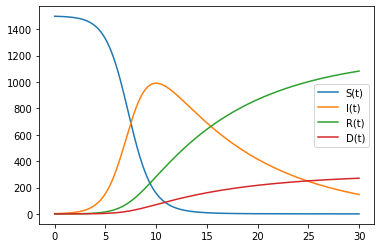

In [53]:
#plotting results

plt.figure(figsize=(6,4))
plt.plot(t, sol[:,0],label = "S(t)")
plt.plot(t, sol[:,1],label = "I(t)")
plt.plot(t, sol[:,2],label = "R(t)")
plt.plot(t, sol[:,3],label = "D(t)")
plt.legend()
plt.show()

In [0]:
PK_S = comp_df_pk['S']
PK_I = comp_df_pk['I']
PK_R = comp_df_pk['R']
PK_D = comp_df_pk['D']

In [0]:
def SIRD(y, t, beta, gamma, alpha, rho):
    S, I, R, D = y
    dS_dt = -1*beta*I*S/N
    dI_dt = (beta*I*S/N) -  (1-alpha)*gamma*I - alpha*rho*I
    dR_dt = (1 - alpha)*gamma*I
    dD_dt = alpha*rho*I
    return dS_dt, dI_dt, dR_dt, dD_dt

In [0]:
def fit_SIRD_odeint(x, beta, gamma, alpha, rho): # x is day num
    return integrate.odeint(SIRD, (S0, I0, R0, D0), x, args=(beta, gamma, alpha, rho))[:,1] # return I values only (ydata)

In [0]:
first_case_index = np.array(test.head(1))[0]

xdata = comp_df_pk.Day_num

N = comp_df_pk['population'][first_case_index]
I0 = comp_df_pk['I'][first_case_index]
S0 = comp_df_pk['S'][first_case_index]
R0 = comp_df_pk['R'][first_case_index]
D0 = comp_df_pk['D'][first_case_index]
popt, pcov = optimize.curve_fit(fit_SIRD_odeint, xdata, PK_I)
fitted = fit_SIRD_odeint(xdata, *popt)

In [0]:
from_tomorrow = len(xdata) +  21 # data of after 21 days of 2020
days_left = 365 - from_tomorrow

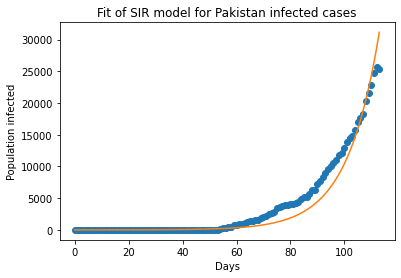

Optimal parameters: beta = 1.1070961327946047 gamma =  0.9989431089638413 alpha =  12.608245538855774 rho =  1.0007282396287023


In [58]:
plt.plot(xdata, PK_I, 'o')
plt.plot(xdata, fitted)
plt.title("Fit of SIR model for Pakistan infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], "gamma = ", popt[1], "alpha = ", popt[2], "rho = ", popt[3])

In [0]:
D1 = comp_df_pk['D'][len(comp_df_pk)-1]
N = comp_df_pk['population'][len(comp_df_pk)-1] - D1
S1 = comp_df_pk['S'][len(comp_df_pk)-1]
I1 = comp_df_pk['I'][len(comp_df_pk)-1]
R1 = comp_df_pk['R'][len(comp_df_pk)-1]
y = S1, I1, R1, D1
x = np.linspace(0, days_left, days_left)
# Integrate the SIR equations over the time grid, x.
ret = odeint(SIRD, y, x , args=(popt[0], popt[1], popt[2], popt[3]))

In [0]:
 #remaining_days = pd.date_range(max(comp_df_pk['date']) , max(comp_df_pk['date']) + timedelta(days=days_left+1))


Predicting the cases througout the year 2020


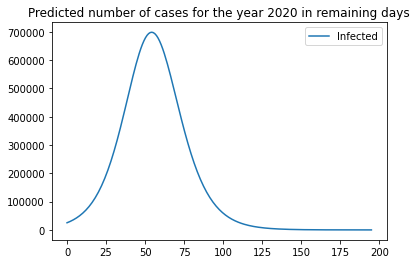

In [101]:
#plotting results
plt.figure(figsize=(6,4))
plt.title('Predicted number of cases for the year 2020 in remaining days')
plt.plot(x, ret[:,1],label = "Infected")
plt.legend()
plt.show()

Our model has predicted approx 700K cases in next 2 months if people continued the violation of social distancing.

## References and Acknowledgements
**Data:**
* [Novel Coronavirus (COVID-19) Cases, provided by JHU CSSE](https://github.com/CSSEGISandData/COVID-19)

* [COVID-19 Complete Dataset (Updated every 24hrs)](https://www.kaggle.com/imdevskp/corona-virus-report)

* [Population by country -2020](https://www.kaggle.com/tanuprabhu/population-by-country-2020)  

* [Pakistan City wise COVID-19 data](https://www.kaggle.com/zusmani/pakistan-corona-virus-citywise-data)

**Notebooks:**
* [COVID Global Forecast SIR + XGBoost](https://www.kaggle.com/kaniya/covid-global-forecast-sir-xgboost/notebook)
